# Quick Draw Neural Network

The [Quick Draw Dataset](https://quickdraw.withgoogle.com/data) is a collection of 50 million drawings across 345 categories, contributed by players of the game Quick, Draw!. The drawings were captured as timestamped vectors, tagged with metadata including what the player was asked to draw and in which country the player was located.

In this notebook I attempt to create a Deep Learning Neural Network to classify the drawings.

After building the model I will build a web applicationt to implement this into [safoan.me](https://www.safoan.me)

## Data Processingdraw
For this project I will make use of the `.npy` Numpy Bitmaps which on top of the simplification:
1. Align the drawing to the top-left corner, to have minimum values of 0.
2. Uniformly scale the drawing, to have a maximum value of 255.
3. Resample all strokes with a 1 pixel spacing.
4. Simplify all strokes using the Ramer–Douglas–Peucker algorithm with an epsilon value of 2.0.

Have also been redered in 28x28 gray scale images into numpy `.npy` format, while also being re-aligned to the center of the drawing bounding box. Due to this being pre-processed it makes it easier to work with.

**Metric** used will be **Accuracy** as the primary goal is to correctly guess as many as possible.

**Install the numpy bitmap "images"**
```bash
    mkdir numpy_bitmap
    gsutil -m cp "gs://quickdraw_dataset/full/numpy_bitmap/*.npy" numpy_bitmap
```

In [1]:
import os
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

For I notice the file names arent standardised, some with capitals, some with spaces so ill begin with that.

Then for runtimes for now I'll only work with 10 categories, as opposed to the total 345. This reduces the data from 50,000,000+ bitmaps, to just bellow 1,500,000

In [2]:
IMAGES_DIR = "numpy_bitmap/"

# standardize filenames
# for filename in os.listdir(IMAGES_DIR):
#     os.rename(IMAGES_DIR + filename, IMAGES_DIR + filename.replace(" ", "_").lower())

cat_a = os.listdir(IMAGES_DIR)
print(f'Total categories: {len(cat_a)} \nAll categories: {cat_a}')

cat_s = cat_a[15:25]
print(f'Sample categories: {cat_s}')

Total categories: 345 
All categories: ['arm.npy', 'bench.npy', 'the_eiffel_tower.npy', 'diving_board.npy', 'baseball_bat.npy', 'bottlecap.npy', 'mailbox.npy', 'calendar.npy', 'aircraft_carrier.npy', 'animal_migration.npy', 'cello.npy', 'bowtie.npy', 'dog.npy', 'axe.npy', 'bat.npy', 'alarm_clock.npy', 'backpack.npy', 'blueberry.npy', 'elephant.npy', 'broom.npy', 'cruise_ship.npy', 'beard.npy', 'ant.npy', 'the_mona_lisa.npy', 'barn.npy', 'cat.npy', 'oven.npy', 'bear.npy', 'bracelet.npy', 'bed.npy', 'basket.npy', 'bee.npy', 'belt.npy', 'baseball.npy', 'car.npy', 'bird.npy', 'birthday_cake.npy', 'apple.npy', 'circle.npy', 'bandage.npy', 'door.npy', 'anvil.npy', 'book.npy', 'blackberry.npy', 'basketball.npy', 'bathtub.npy', 'ambulance.npy', 'bridge.npy', 'asparagus.npy', 'clarinet.npy', 'eyeglasses.npy', 'airplane.npy', 'brain.npy', 'angel.npy', 'broccoli.npy', 'banana.npy', 'clock.npy', 'the_great_wall_of_china.npy', 'helicopter.npy', 'binoculars.npy', 'cloud.npy', 'beach.npy', 'dumbbell.

In [3]:
# add all drawings into a dataframe
bmap_split = pd.DataFrame()
bmap = pd.DataFrame()
bitmaps = []

for category in cat_s:
    data = pd.DataFrame(np.load(IMAGES_DIR + category))
    data["category"] = category
    bitmaps.append(data)
    
bmap_split = pd.concat(bitmaps, ignore_index=True)
bmap_split.sample(5)

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,category
398492,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,elephant.npy
551853,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,broom.npy
937272,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,ant.npy
1118126,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,the_mona_lisa.npy
867945,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,beard.npy


In [4]:
bmap["y"] = bmap_split["category"].apply(lambda x: x.split(".")[0])
bmap["X"] = bmap_split.iloc[:, :-1].apply(lambda x: np.array(x).reshape(28,28), axis=1)

Lets take a look at a couple of images using `matplitlib`

,y,X
951400,ant,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
1107710,the_mona_lisa,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
759108,beard,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
65180,alarm_clock,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
1016625,ant,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
627465,cruise_ship,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
651566,cruise_ship,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
252924,blueberry,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
796004,beard,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
631158,cruise_ship,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."


In [57]:
def show_images(df, n_images):
    
    '''
    Converting n_images of bitmap arrays into images
    
    parameters:
    df: dataframe with X and y columns, 
        X: bitmap array
        y: category label
    n_images: number of images to display
    
    returns: 
    figure with n_images labelled
    '''
    fig_h = 1.5 * (n_images//10) # height of the figure
    fig, axs = plt.subplots(n_images//10, 10, figsize=(12, fig_h))
    axs = axs.flatten() # 2D - 1D to make it simpler to iterate trough, eg: ax[0,0] -> ax[0]
    
    random_sample = df.sample(n_images)
    label = random_sample['y'].values
    image = random_sample['X'].values
    
    for x in range(n_images):
        axs[x].imshow(image[x])
        axs[x].set_title(label[x])
        axs[x].axis('off')  # Hide the axes for better visualization
    
    plt.tight_layout()
    plt.show()

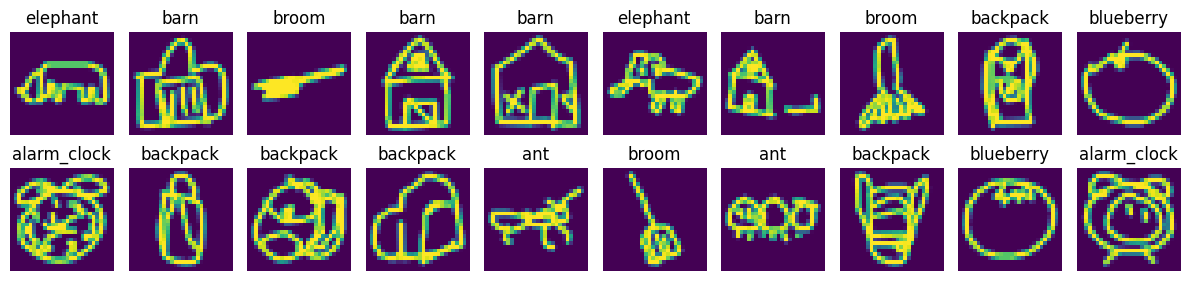

In [58]:
show_images(bmap, 20)